# Versión con Ajuste Fino (Fine-Tuning) para el modelo multi-salida

Esta versión del código implementa el ajuste fino descongelando las últimas capas del modelo base EfficientNetB0 para mejorar la adaptación a tu conjunto de datos.

In [10]:
# Importar librerías necesarias
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [11]:
# =============================================
# CONFIGURACIÓN
# =============================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 30  # Entrenamiento inicial con base congelada
EPOCHS_FINE_TUNE = 30  # Entrenamiento con ajuste fino
LEARNING_RATE_INITIAL = 5e-5  # Ajuste de tasa de aprendizaje inicial
LEARNING_RATE_FINE_TUNE = 5e-6  # Ajuste de tasa de aprendizaje para fine-tuning
BASE_MODEL = 'EfficientNetB0'

In [12]:
# =============================================
# DICCIONARIOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

In [13]:
# =============================================
# CARGA DE DATOS
# =============================================
def load_and_prepare_data(split_dir):
    """Carga imágenes y etiquetas para un conjunto (train/val/test)"""
    df = pd.read_csv(f'{split_dir}/{split_dir.split("/")[-1]}_set.csv', sep='|')
    # Convertir strings de listas a listas reales
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    return df

# Cargar todos los conjuntos
train_df = load_and_prepare_data('data/fotos_siniestros/train')
val_df = load_and_prepare_data('data/fotos_siniestros/val')
test_df = load_and_prepare_data('data/fotos_siniestros/test')

In [14]:
# =============================================
# PREPARACIÓN DE ETIQUETAS
# =============================================
mlb_partes = MultiLabelBinarizer()
mlb_dannos = MultiLabelBinarizer()
mlb_sugerencias = MultiLabelBinarizer()

y_train_partes = mlb_partes.fit_transform(train_df['partes'])
y_train_dannos = mlb_dannos.fit_transform(train_df['dannos'])
y_train_sugerencias = mlb_sugerencias.fit_transform(train_df['sugerencias'])

y_val_partes = mlb_partes.transform(val_df['partes'])
y_val_dannos = mlb_dannos.transform(val_df['dannos'])
y_val_sugerencias = mlb_sugerencias.transform(val_df['sugerencias'])

# Guardar MultiLabelBinarizer objects para uso posterior
import pickle
with open("mlb_partes.pkl", "wb") as f:
    pickle.dump(mlb_partes, f)
with open("mlb_dannos.pkl", "wb") as f:
    pickle.dump(mlb_dannos, f)
with open("mlb_sugerencias.pkl", "wb") as f:
    pickle.dump(mlb_sugerencias, f)
print("MultiLabelBinarizer objects saved.")

MultiLabelBinarizer objects saved.


In [15]:
# =============================================
# GENERADOR DE DATOS
# =============================================
class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None):
        self.df = df
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.empty((len(batch_df), *self.img_size, 3))
        y_partes = []
        y_dannos = []
        y_sugerencias = []
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
                
            img_array = applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            
            y_partes.append(row['partes'])
            y_dannos.append(row['dannos'])
            y_sugerencias.append(row['sugerencias'])
        
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

IMG_DIR = '../data/fotos_siniestros/'

train_generator = MultiLabelDataGenerator(
    train_df, 
    IMG_DIR, 
    mlb_partes, 
    mlb_dannos, 
    mlb_sugerencias,
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augmentation=train_datagen
)

val_generator = MultiLabelDataGenerator(
    val_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

test_generator = MultiLabelDataGenerator(
    test_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

In [16]:
# =============================================
# CONSTRUCCIÓN DEL MODELO CON AJUSTE FINO Y MEJORAS
# =============================================
# Last Execution 8:11:46 PM
# Execution Time 13m 22.2s
# Overhead Time 110ms
# Render Times
# VS Code Builtin Notebook Output Renderer 56ms

def build_multi_output_model_fine_tuning(input_shape, num_partes, num_dannos, num_sugerencias, base_model_name='EfficientNetB0'):
    if base_model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(
            include_top=False, 
            weights='imagenet', 
            input_shape=input_shape
        )
    elif base_model_name == 'ResNet50':
        base_model = applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Modelo base no soportado: {base_model_name}")

    # Congelar todas las capas inicialmente
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Reducido dropout para menos regularización

    output_partes = layers.Dense(num_partes, activation='sigmoid', name='partes')(x)
    output_dannos = layers.Dense(num_dannos, activation='sigmoid', name='dannos')(x)
    output_sugerencias = layers.Dense(num_sugerencias, activation='sigmoid', name='sugerencias')(x)

    model = models.Model(
        inputs=inputs,
        outputs=[output_partes, output_dannos, output_sugerencias]
    )

    return model

# Construir modelo
model = build_multi_output_model_fine_tuning(
    input_shape=(*IMG_SIZE, 3),
    num_partes=len(mlb_partes.classes_),
    num_dannos=len(mlb_dannos.classes_),
    num_sugerencias=len(mlb_sugerencias.classes_),
    base_model_name=BASE_MODEL
)

# Compilar para entrenamiento inicial
model.compile(
    optimizer=Adam(learning_rate=5e-5),  # tasa de aprendizaje inicial ajustada
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_fine_tuning.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento inicial con base congelada
history_initial = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_INITIAL,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Descongelar últimas capas para ajuste fino
base_model = model.layers[1]  # Asumiendo que la segunda capa es el modelo base
base_model.trainable = True

# Congelar todas las capas excepto las últimas 30 (más capas descongeladas)
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompilar con tasa de aprendizaje menor
model.compile(
    optimizer=Adam(learning_rate=5e-6),  # tasa de aprendizaje para fine-tuning ajustada
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Entrenamiento con ajuste fino
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINE_TUNE,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Guardar modelo final
model.save('final_model_fine_tuned_v2.keras')

/data/Python/DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetasTF_APIs/.venv-3-11/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - dannos_accuracy: 0.1822 - dannos_loss: 0.6558 - loss: 2.0491 - partes_accuracy: 0.0469 - partes_loss: 0.7035 - sugerencias_accuracy: 0.5476 - sugerencias_loss: 0.6902
Epoch 1: val_loss improved from inf to 1.73822, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 718ms/step - dannos_accuracy: 0.1836 - dannos_loss: 0.6545 - loss: 2.0450 - partes_accuracy: 0.0470 - partes_loss: 0.7023 - sugerencias_accuracy: 0.5518 - sugerencias_loss: 0.6889 - val_dannos_accuracy: 0.3275 - val_dannos_loss: 0.5671 - val_loss: 1.7382 - val_partes_accuracy: 0.0760 - val_partes_loss: 0.5960 - val_sugerencias_accuracy: 0.8363 - val_sugerencias_loss: 0.5890
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - dannos_accuracy: 0.3335 - dannos_loss: 0.5330 - loss: 1.6641 - partes_accuracy: 0.0483 - partes_loss: 0.5634 - sugerencias_accuracy: 0.7776 - sugerencias_loss: 0.5885
Epoch 2: val_loss improved from 1.73822 to 1.52995, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 681ms/step - dannos_accuracy: 0.3340 - dannos_loss: 0.5325 - loss: 1.6621 - partes_accuracy: 0.0488 - partes_loss: 0.5625 - sugerencias_accuracy: 0.7784 - sugerencias_loss: 0.5881 - val_dannos_accuracy: 0.3977 - val_dannos_loss: 0.5083 - val_loss: 1.5300 - val_partes_accuracy: 0.1053 - val_partes_loss: 0.4982 - val_sugerencias_accuracy: 0.8480 - val_sugerencias_loss: 0.5403
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - dannos_accuracy: 0.3814 - dannos_loss: 0.4774 - loss: 1.4660 - partes_accuracy: 0.0789 - partes_loss: 0.4656 - sugerencias_accuracy: 0.8204 - sugerencias_loss: 0.5134
Epoch 3: val_loss improved from 1.52995 to 1.38434, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 838ms/step - dannos_accuracy: 0.3818 - dannos_loss: 0.4774 - loss: 1.4650 - partes_accuracy: 0.0787 - partes_loss: 0.4649 - sugerencias_accuracy: 0.8207 - sugerencias_loss: 0.5134 - val_dannos_accuracy: 0.4444 - val_dannos_loss: 0.4764 - val_loss: 1.3843 - val_partes_accuracy: 0.1287 - val_partes_loss: 0.4230 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.5021
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - dannos_accuracy: 0.4300 - dannos_loss: 0.4473 - loss: 1.3411 - partes_accuracy: 0.0560 - partes_loss: 0.3905 - sugerencias_accuracy: 0.8414 - sugerencias_loss: 0.5036
Epoch 4: val_loss improved from 1.38434 to 1.27638, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 842ms/step - dannos_accuracy: 0.4293 - dannos_loss: 0.4476 - loss: 1.3404 - partes_accuracy: 0.0567 - partes_loss: 0.3902 - sugerencias_accuracy: 0.8414 - sugerencias_loss: 0.5030 - val_dannos_accuracy: 0.4678 - val_dannos_loss: 0.4560 - val_loss: 1.2764 - val_partes_accuracy: 0.1579 - val_partes_loss: 0.3671 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.4700
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - dannos_accuracy: 0.4350 - dannos_loss: 0.4393 - loss: 1.2447 - partes_accuracy: 0.1022 - partes_loss: 0.3352 - sugerencias_accuracy: 0.8558 - sugerencias_loss: 0.4676
Epoch 5: val_loss improved from 1.27638 to 1.19696, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 811ms/step - dannos_accuracy: 0.4340 - dannos_loss: 0.4392 - loss: 1.2438 - partes_accuracy: 0.1024 - partes_loss: 0.3348 - sugerencias_accuracy: 0.8561 - sugerencias_loss: 0.4671 - val_dannos_accuracy: 0.4795 - val_dannos_loss: 0.4428 - val_loss: 1.1970 - val_partes_accuracy: 0.1754 - val_partes_loss: 0.3293 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.4421
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - dannos_accuracy: 0.4594 - dannos_loss: 0.4279 - loss: 1.1843 - partes_accuracy: 0.1104 - partes_loss: 0.3022 - sugerencias_accuracy: 0.8685 - sugerencias_loss: 0.4532
Epoch 6: val_loss improved from 1.19696 to 1.14259, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 829ms/step - dannos_accuracy: 0.4597 - dannos_loss: 0.4280 - loss: 1.1836 - partes_accuracy: 0.1103 - partes_loss: 0.3020 - sugerencias_accuracy: 0.8691 - sugerencias_loss: 0.4525 - val_dannos_accuracy: 0.4854 - val_dannos_loss: 0.4324 - val_loss: 1.1426 - val_partes_accuracy: 0.2047 - val_partes_loss: 0.3049 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.4220
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - dannos_accuracy: 0.4987 - dannos_loss: 0.4256 - loss: 1.1251 - partes_accuracy: 0.1579 - partes_loss: 0.2814 - sugerencias_accuracy: 0.8893 - sugerencias_loss: 0.4131
Epoch 7: val_loss improved from 1.14259 to 1.10072, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 719ms/step - dannos_accuracy: 0.4992 - dannos_loss: 0.4253 - loss: 1.1251 - partes_accuracy: 0.1577 - partes_loss: 0.2813 - sugerencias_accuracy: 0.8886 - sugerencias_loss: 0.4131 - val_dannos_accuracy: 0.5146 - val_dannos_loss: 0.4223 - val_loss: 1.1007 - val_partes_accuracy: 0.2222 - val_partes_loss: 0.2882 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.4055
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - dannos_accuracy: 0.5092 - dannos_loss: 0.4239 - loss: 1.0927 - partes_accuracy: 0.1663 - partes_loss: 0.2777 - sugerencias_accuracy: 0.8751 - sugerencias_loss: 0.4208
Epoch 8: val_loss improved from 1.10072 to 1.07587, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 782ms/step - dannos_accuracy: 0.5094 - dannos_loss: 0.4239 - loss: 1.0927 - partes_accuracy: 0.1664 - partes_loss: 0.2776 - sugerencias_accuracy: 0.8750 - sugerencias_loss: 0.4207 - val_dannos_accuracy: 0.5380 - val_dannos_loss: 0.4144 - val_loss: 1.0759 - val_partes_accuracy: 0.2339 - val_partes_loss: 0.2771 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3973
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - dannos_accuracy: 0.5594 - dannos_loss: 0.4152 - loss: 1.0814 - partes_accuracy: 0.1449 - partes_loss: 0.2641 - sugerencias_accuracy: 0.8758 - sugerencias_loss: 0.4156
Epoch 9: val_loss improved from 1.07587 to 1.04853, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 830ms/step - dannos_accuracy: 0.5588 - dannos_loss: 0.4150 - loss: 1.0810 - partes_accuracy: 0.1455 - partes_loss: 0.2641 - sugerencias_accuracy: 0.8758 - sugerencias_loss: 0.4154 - val_dannos_accuracy: 0.5439 - val_dannos_loss: 0.4072 - val_loss: 1.0485 - val_partes_accuracy: 0.2515 - val_partes_loss: 0.2690 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3842
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - dannos_accuracy: 0.5196 - dannos_loss: 0.4016 - loss: 1.0435 - partes_accuracy: 0.1864 - partes_loss: 0.2588 - sugerencias_accuracy: 0.8736 - sugerencias_loss: 0.3819
Epoch 10: val_loss improved from 1.04853 to 1.02680, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 817ms/step - dannos_accuracy: 0.5203 - dannos_loss: 0.4014 - loss: 1.0434 - partes_accuracy: 0.1864 - partes_loss: 0.2588 - sugerencias_accuracy: 0.8736 - sugerencias_loss: 0.3817 - val_dannos_accuracy: 0.5439 - val_dannos_loss: 0.4010 - val_loss: 1.0268 - val_partes_accuracy: 0.2632 - val_partes_loss: 0.2624 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3766
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - dannos_accuracy: 0.5232 - dannos_loss: 0.3903 - loss: 1.0153 - partes_accuracy: 0.1804 - partes_loss: 0.2500 - sugerencias_accuracy: 0.8804 - sugerencias_loss: 0.3678
Epoch 11: val_loss improved from 1.02680 to 1.01083, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 781ms/step - dannos_accuracy: 0.5230 - dannos_loss: 0.3905 - loss: 1.0158 - partes_accuracy: 0.1811 - partes_loss: 0.2499 - sugerencias_accuracy: 0.8802 - sugerencias_loss: 0.3676 - val_dannos_accuracy: 0.5380 - val_dannos_loss: 0.3951 - val_loss: 1.0108 - val_partes_accuracy: 0.2632 - val_partes_loss: 0.2573 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3713
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - dannos_accuracy: 0.5321 - dannos_loss: 0.4003 - loss: 1.0119 - partes_accuracy: 0.2061 - partes_loss: 0.2470 - sugerencias_accuracy: 0.8644 - sugerencias_loss: 0.3824
Epoch 12: val_loss improved from 1.01083 to 0.99677, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 664ms/step - dannos_accuracy: 0.5328 - dannos_loss: 0.4002 - loss: 1.0117 - partes_accuracy: 0.2064 - partes_loss: 0.2469 - sugerencias_accuracy: 0.8650 - sugerencias_loss: 0.3824 - val_dannos_accuracy: 0.5673 - val_dannos_loss: 0.3907 - val_loss: 0.9968 - val_partes_accuracy: 0.2924 - val_partes_loss: 0.2531 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.3668
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - dannos_accuracy: 0.5989 - dannos_loss: 0.3850 - loss: 0.9927 - partes_accuracy: 0.1999 - partes_loss: 0.2461 - sugerencias_accuracy: 0.8714 - sugerencias_loss: 0.3641
Epoch 13: val_loss improved from 0.99677 to 0.98488, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 671ms/step - dannos_accuracy: 0.5971 - dannos_loss: 0.3855 - loss: 0.9930 - partes_accuracy: 0.2003 - partes_loss: 0.2461 - sugerencias_accuracy: 0.8712 - sugerencias_loss: 0.3640 - val_dannos_accuracy: 0.5205 - val_dannos_loss: 0.3870 - val_loss: 0.9849 - val_partes_accuracy: 0.2982 - val_partes_loss: 0.2498 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.3617
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - dannos_accuracy: 0.5472 - dannos_loss: 0.3779 - loss: 0.9615 - partes_accuracy: 0.2252 - partes_loss: 0.2468 - sugerencias_accuracy: 0.8724 - sugerencias_loss: 0.3355
Epoch 14: val_loss improved from 0.98488 to 0.97917, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 675ms/step - dannos_accuracy: 0.5472 - dannos_loss: 0.3777 - loss: 0.9618 - partes_accuracy: 0.2255 - partes_loss: 0.2467 - sugerencias_accuracy: 0.8729 - sugerencias_loss: 0.3359 - val_dannos_accuracy: 0.5322 - val_dannos_loss: 0.3822 - val_loss: 0.9792 - val_partes_accuracy: 0.3099 - val_partes_loss: 0.2466 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.3617
Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - dannos_accuracy: 0.5248 - dannos_loss: 0.3911 - loss: 0.9849 - partes_accuracy: 0.2562 - partes_loss: 0.2442 - sugerencias_accuracy: 0.8820 - sugerencias_loss: 0.3433
Epoch 15: val_loss improved from 0.97917 to 0.96446, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 671ms/step - dannos_accuracy: 0.5255 - dannos_loss: 0.3906 - loss: 0.9842 - partes_accuracy: 0.2557 - partes_loss: 0.2441 - sugerencias_accuracy: 0.8816 - sugerencias_loss: 0.3432 - val_dannos_accuracy: 0.5380 - val_dannos_loss: 0.3778 - val_loss: 0.9645 - val_partes_accuracy: 0.3216 - val_partes_loss: 0.2432 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.3562
Epoch 16/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - dannos_accuracy: 0.5821 - dannos_loss: 0.3465 - loss: 0.8982 - partes_accuracy: 0.2579 - partes_loss: 0.2325 - sugerencias_accuracy: 0.9016 - sugerencias_loss: 0.2768
Epoch 16: val_loss improved from 0.96446 to 0.95222, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 710ms/step - dannos_accuracy: 0.5813 - dannos_loss: 0.3472 - loss: 0.9001 - partes_accuracy: 0.2570 - partes_loss: 0.2327 - sugerencias_accuracy: 0.9008 - sugerencias_loss: 0.2786 - val_dannos_accuracy: 0.5497 - val_dannos_loss: 0.3733 - val_loss: 0.9522 - val_partes_accuracy: 0.3216 - val_partes_loss: 0.2404 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.3521
Epoch 17/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - dannos_accuracy: 0.5661 - dannos_loss: 0.3863 - loss: 0.9639 - partes_accuracy: 0.2445 - partes_loss: 0.2423 - sugerencias_accuracy: 0.8853 - sugerencias_loss: 0.3712
Epoch 17: val_loss improved from 0.95222 to 0.94926, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 681ms/step - dannos_accuracy: 0.5663 - dannos_loss: 0.3860 - loss: 0.9635 - partes_accuracy: 0.2443 - partes_loss: 0.2423 - sugerencias_accuracy: 0.8848 - sugerencias_loss: 0.3708 - val_dannos_accuracy: 0.5556 - val_dannos_loss: 0.3712 - val_loss: 0.9493 - val_partes_accuracy: 0.3333 - val_partes_loss: 0.2383 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3520
Epoch 18/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - dannos_accuracy: 0.5840 - dannos_loss: 0.4101 - loss: 0.9554 - partes_accuracy: 0.2496 - partes_loss: 0.2531 - sugerencias_accuracy: 0.8742 - sugerencias_loss: 0.3284
Epoch 18: val_loss improved from 0.94926 to 0.93879, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 679ms/step - dannos_accuracy: 0.5840 - dannos_loss: 0.4092 - loss: 0.9550 - partes_accuracy: 0.2497 - partes_loss: 0.2529 - sugerencias_accuracy: 0.8740 - sugerencias_loss: 0.3288 - val_dannos_accuracy: 0.5848 - val_dannos_loss: 0.3698 - val_loss: 0.9388 - val_partes_accuracy: 0.3333 - val_partes_loss: 0.2361 - val_sugerencias_accuracy: 0.9181 - val_sugerencias_loss: 0.3477
Epoch 19/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - dannos_accuracy: 0.6000 - dannos_loss: 0.3609 - loss: 0.9187 - partes_accuracy: 0.2382 - partes_loss: 0.2323 - sugerencias_accuracy: 0.8733 - sugerencias_loss: 0.3326
Epoch 19: val_loss improved from 0.93879 to 0.93244, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 681ms/step - dannos_accuracy: 0.5993 - dannos_loss: 0.3613 - loss: 0.9197 - partes_accuracy: 0.2387 - partes_loss: 0.2323 - sugerencias_accuracy: 0.8730 - sugerencias_loss: 0.3334 - val_dannos_accuracy: 0.5614 - val_dannos_loss: 0.3666 - val_loss: 0.9324 - val_partes_accuracy: 0.3450 - val_partes_loss: 0.2335 - val_sugerencias_accuracy: 0.9123 - val_sugerencias_loss: 0.3484
Epoch 20/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - dannos_accuracy: 0.5861 - dannos_loss: 0.3529 - loss: 0.9172 - partes_accuracy: 0.2538 - partes_loss: 0.2331 - sugerencias_accuracy: 0.8578 - sugerencias_loss: 0.3262
Epoch 20: val_loss improved from 0.93244 to 0.92800, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 684ms/step - dannos_accuracy: 0.5863 - dannos_loss: 0.3530 - loss: 0.9170 - partes_accuracy: 0.2537 - partes_loss: 0.2329 - sugerencias_accuracy: 0.8584 - sugerencias_loss: 0.3258 - val_dannos_accuracy: 0.5556 - val_dannos_loss: 0.3633 - val_loss: 0.9280 - val_partes_accuracy: 0.3450 - val_partes_loss: 0.2309 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3490
Epoch 21/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - dannos_accuracy: 0.5525 - dannos_loss: 0.3572 - loss: 0.9324 - partes_accuracy: 0.2728 - partes_loss: 0.2249 - sugerencias_accuracy: 0.8690 - sugerencias_loss: 0.3512
Epoch 21: val_loss improved from 0.92800 to 0.92382, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 686ms/step - dannos_accuracy: 0.5535 - dannos_loss: 0.3571 - loss: 0.9320 - partes_accuracy: 0.2730 - partes_loss: 0.2250 - sugerencias_accuracy: 0.8691 - sugerencias_loss: 0.3512 - val_dannos_accuracy: 0.5906 - val_dannos_loss: 0.3609 - val_loss: 0.9238 - val_partes_accuracy: 0.3567 - val_partes_loss: 0.2289 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3484
Epoch 22/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - dannos_accuracy: 0.6280 - dannos_loss: 0.3423 - loss: 0.8918 - partes_accuracy: 0.2959 - partes_loss: 0.2250 - sugerencias_accuracy: 0.8742 - sugerencias_loss: 0.3262
Epoch 22: val_loss improved from 0.92382 to 0.91804, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 683ms/step - dannos_accuracy: 0.6270 - dannos_loss: 0.3423 - loss: 0.8919 - partes_accuracy: 0.2957 - partes_loss: 0.2248 - sugerencias_accuracy: 0.8742 - sugerencias_loss: 0.3271 - val_dannos_accuracy: 0.5848 - val_dannos_loss: 0.3589 - val_loss: 0.9180 - val_partes_accuracy: 0.3567 - val_partes_loss: 0.2269 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.3465
Epoch 23/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - dannos_accuracy: 0.5692 - dannos_loss: 0.3472 - loss: 0.9060 - partes_accuracy: 0.2798 - partes_loss: 0.2247 - sugerencias_accuracy: 0.8705 - sugerencias_loss: 0.3281
Epoch 23: val_loss improved from 0.91804 to 0.91010, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 686ms/step - dannos_accuracy: 0.5697 - dannos_loss: 0.3470 - loss: 0.9061 - partes_accuracy: 0.2794 - partes_loss: 0.2246 - sugerencias_accuracy: 0.8706 - sugerencias_loss: 0.3277 - val_dannos_accuracy: 0.5906 - val_dannos_loss: 0.3562 - val_loss: 0.9101 - val_partes_accuracy: 0.3743 - val_partes_loss: 0.2250 - val_sugerencias_accuracy: 0.9123 - val_sugerencias_loss: 0.3456
Epoch 24/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - dannos_accuracy: 0.6000 - dannos_loss: 0.3550 - loss: 0.8893 - partes_accuracy: 0.3016 - partes_loss: 0.2287 - sugerencias_accuracy: 0.8848 - sugerencias_loss: 0.3164
Epoch 24: val_loss did not improve from 0.91010
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 675ms/step - dannos_accuracy: 0.6002 - dannos_loss: 0.3552 - loss: 0.8896 - partes_accuracy: 0.3016 - partes_loss: 0.2286 - sugerencias_accuracy: 0.8844 - sugerencias_loss: 0.3174 - val_dannos_accuracy: 0.5906 - val_dannos_loss: 0.3551 - val_loss: 0.9173 - val_partes_accuracy: 0.3743 - val_

26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 692ms/step - dannos_accuracy: 0.6290 - dannos_loss: 0.3554 - loss: 0.8809 - partes_accuracy: 0.2904 - partes_loss: 0.2286 - sugerencias_accuracy: 0.8794 - sugerencias_loss: 0.3256 - val_dannos_accuracy: 0.5965 - val_dannos_loss: 0.3536 - val_loss: 0.9059 - val_partes_accuracy: 0.3743 - val_partes_loss: 0.2224 - val_sugerencias_accuracy: 0.9064 - val_sugerencias_loss: 0.3453
Epoch 26/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - dannos_accuracy: 0.6155 - dannos_loss: 0.3425 - loss: 0.8598 - partes_accuracy: 0.2853 - partes_loss: 0.2142 - sugerencias_accuracy: 0.8676 - sugerencias_loss: 0.3008
Epoch 26: val_loss improved from 0.90589 to 0.89993, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 692ms/step - dannos_accuracy: 0.6155 - dannos_loss: 0.3422 - loss: 0.8600 - partes_accuracy: 0.2855 - partes_loss: 0.2141 - sugerencias_accuracy: 0.8679 - sugerencias_loss: 0.3008 - val_dannos_accuracy: 0.6140 - val_dannos_loss: 0.3504 - val_loss: 0.8999 - val_partes_accuracy: 0.3743 - val_partes_loss: 0.2208 - val_sugerencias_accuracy: 0.9123 - val_sugerencias_loss: 0.3450
Epoch 27/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - dannos_accuracy: 0.6241 - dannos_loss: 0.3354 - loss: 0.8628 - partes_accuracy: 0.3098 - partes_loss: 0.2225 - sugerencias_accuracy: 0.8733 - sugerencias_loss: 0.3047
Epoch 27: val_loss improved from 0.89993 to 0.89628, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 688ms/step - dannos_accuracy: 0.6240 - dannos_loss: 0.3354 - loss: 0.8627 - partes_accuracy: 0.3098 - partes_loss: 0.2224 - sugerencias_accuracy: 0.8733 - sugerencias_loss: 0.3046 - val_dannos_accuracy: 0.6023 - val_dannos_loss: 0.3482 - val_loss: 0.8963 - val_partes_accuracy: 0.3684 - val_partes_loss: 0.2190 - val_sugerencias_accuracy: 0.9064 - val_sugerencias_loss: 0.3450
Epoch 28/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - dannos_accuracy: 0.6040 - dannos_loss: 0.3283 - loss: 0.8596 - partes_accuracy: 0.3381 - partes_loss: 0.2112 - sugerencias_accuracy: 0.8725 - sugerencias_loss: 0.3167
Epoch 28: val_loss improved from 0.89628 to 0.89149, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 679ms/step - dannos_accuracy: 0.6037 - dannos_loss: 0.3286 - loss: 0.8593 - partes_accuracy: 0.3372 - partes_loss: 0.2113 - sugerencias_accuracy: 0.8725 - sugerencias_loss: 0.3159 - val_dannos_accuracy: 0.6140 - val_dannos_loss: 0.3466 - val_loss: 0.8915 - val_partes_accuracy: 0.3684 - val_partes_loss: 0.2174 - val_sugerencias_accuracy: 0.9064 - val_sugerencias_loss: 0.3451
Epoch 29/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - dannos_accuracy: 0.5935 - dannos_loss: 0.3384 - loss: 0.8728 - partes_accuracy: 0.3307 - partes_loss: 0.2113 - sugerencias_accuracy: 0.8675 - sugerencias_loss: 0.3391
Epoch 29: val_loss improved from 0.89149 to 0.88576, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 672ms/step - dannos_accuracy: 0.5934 - dannos_loss: 0.3383 - loss: 0.8724 - partes_accuracy: 0.3297 - partes_loss: 0.2113 - sugerencias_accuracy: 0.8676 - sugerencias_loss: 0.3389 - val_dannos_accuracy: 0.6374 - val_dannos_loss: 0.3466 - val_loss: 0.8858 - val_partes_accuracy: 0.3801 - val_partes_loss: 0.2160 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.3475
Epoch 30/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - dannos_accuracy: 0.6123 - dannos_loss: 0.3427 - loss: 0.9180 - partes_accuracy: 0.3104 - partes_loss: 0.2201 - sugerencias_accuracy: 0.8661 - sugerencias_loss: 0.3464
Epoch 30: val_loss improved from 0.88576 to 0.88327, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 680ms/step - dannos_accuracy: 0.6123 - dannos_loss: 0.3422 - loss: 0.9164 - partes_accuracy: 0.3104 - partes_loss: 0.2199 - sugerencias_accuracy: 0.8664 - sugerencias_loss: 0.3451 - val_dannos_accuracy: 0.6257 - val_dannos_loss: 0.3439 - val_loss: 0.8833 - val_partes_accuracy: 0.3684 - val_partes_loss: 0.2150 - val_sugerencias_accuracy: 0.9123 - val_sugerencias_loss: 0.3420
Restoring model weights from the end of the best epoch: 30.
Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - dannos_accuracy: 0.5529 - dannos_loss: 0.4541 - loss: 1.2679 - partes_accuracy: 0.2957 - partes_loss: 0.3358 - sugerencias_accuracy: 0.7077 - sugerencias_loss: 0.4801
Epoch 1: val_loss did not improve from 0.88327
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 814ms/step - dannos_accuracy: 0.5530 - dannos_loss: 0.4540 - loss: 1.2676 - partes_accuracy: 0.2957 - partes_loss: 0.3358 - sugerencias_accuracy: 0.7082 - sugerencias_loss: 0.4799 - val_dannos_accuracy: 0.6140 - val_dannos_loss: 0.35

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ partes (Dense)      │ (None, 22)        │     11,286 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dannos (Dense)      │ (None, 6)         │      3,078 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sugerencias (Dense) │ (None, 2)         │      1,026 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,055,679 (34.54 MB)

 Trainable params: 2,167,422 (8.27 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

 Optimizer params: 4,334,846 (16.54 MB)

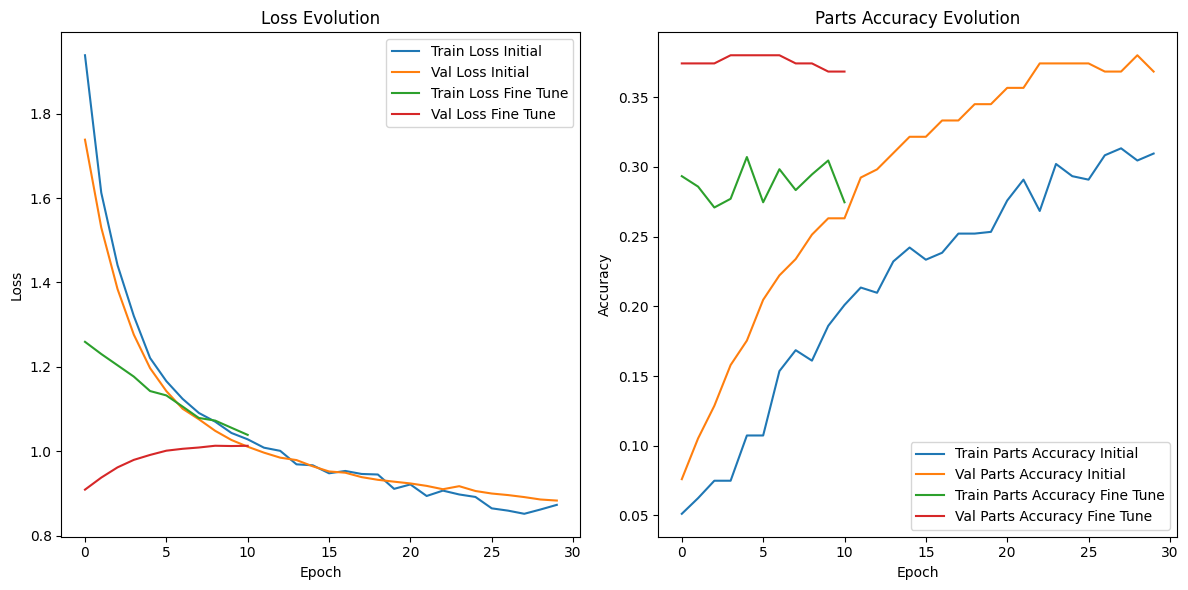

In [18]:
# Función para visualizar el historial de entrenamiento
def plot_training_history(history1, history2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label='Train Loss Initial')
    plt.plot(history1.history['val_loss'], label='Val Loss Initial')
    plt.plot(history2.history['loss'], label='Train Loss Fine Tune')
    plt.plot(history2.history['val_loss'], label='Val Loss Fine Tune')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['partes_accuracy'], label='Train Parts Accuracy Initial')
    plt.plot(history1.history['val_partes_accuracy'], label='Val Parts Accuracy Initial')
    plt.plot(history2.history['partes_accuracy'], label='Train Parts Accuracy Fine Tune')
    plt.plot(history2.history['val_partes_accuracy'], label='Val Parts Accuracy Fine Tune')
    plt.title('Parts Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizar resultados
plot_training_history(history_initial, history_fine_tune)

In [19]:
# =============================================
# EVALUACIÓN
# =============================================
def evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias):
    """Evalúa el modelo en el conjunto de prueba y muestra métricas"""
    # Evaluación general
    results = model.evaluate(test_generator, verbose=1)
    print(f"Pérdida total: {results[0]}")
    print(f"Pérdida partes: {results[1]} - Accuracy partes: {results[4]}")
    print(f"Pérdida daños: {results[2]} - Accuracy daños: {results[5]}")
    print(f"Pérdida sugerencias: {results[3]} - Accuracy sugerencias: {results[6]}")

    # Predicciones
    print("\nGenerando predicciones...")
    predictions = model.predict(test_generator, verbose=1)
    y_pred_partes = predictions[0] > 0.5
    y_pred_dannos = predictions[1] > 0.5
    y_pred_sugerencias = predictions[2] > 0.5

    # Obtener etiquetas verdaderas
    y_true_partes = test_generator.mlb_partes.transform(test_df['partes'])
    y_true_dannos = test_generator.mlb_dannos.transform(test_df['dannos'])
    y_true_sugerencias = test_generator.mlb_sugerencias.transform(test_df['sugerencias'])

    # Convertir IDs de clases a nombres
    def get_class_names(classes, label_dict):
        return [str(label_dict.get(int(cls), f"Clase_{cls}")) for cls in classes]

    partes_names = get_class_names(mlb_partes.classes_, label_to_cls_piezas)
    dannos_names = get_class_names(mlb_dannos.classes_, label_to_cls_danos)
    sugerencias_names = get_class_names(mlb_sugerencias.classes_, label_to_cls_sugerencias)

    # Reportes de clasificación
    print("\nReporte para Partes:")
    print(classification_report(
        y_true_partes,
        y_pred_partes,
        target_names=partes_names,
        zero_division=0
    ))

    print("\nReporte para Daños:")
    print(classification_report(
        y_true_dannos,
        y_pred_dannos,
        target_names=dannos_names,
        zero_division=0
    ))

    print("\nReporte para Sugerencias:")
    print(classification_report(
        y_true_sugerencias,
        y_pred_sugerencias,
        target_names=sugerencias_names,
        zero_division=0
    ))

    return {
        'results': results,
        'predictions': {
            'partes': y_pred_partes,
            'dannos': y_pred_dannos,
            'sugerencias': y_pred_sugerencias
        },
        'true_labels': {
            'partes': y_true_partes,
            'dannos': y_true_dannos,
            'sugerencias': y_true_sugerencias
        }
    }

# Realizar evaluación
evaluation_results = evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - dannos_accuracy: 0.6134 - dannos_loss: 0.3607 - loss: 0.9033 - partes_accuracy: 0.3844 - partes_loss: 0.2140 - sugerencias_accuracy: 0.8657 - sugerencias_loss: 0.3269
Pérdida total: 0.9158827066421509
Pérdida partes: 0.2235080599784851 - Accuracy partes: 0.6127167344093323
Pérdida daños: 0.3748278319835663 - Accuracy daños: 0.3815028965473175
Pérdida sugerencias: 0.31130287051200867 - Accuracy sugerencias: 0.8670520186424255

Generando predicciones...
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 681ms/step

Reporte para Partes:
                                  precision    recall  f1-score   support

                            Capó       0.00      0.00      0.00        12
                   Faros derecho       0.00      0.00      0.00        11
                 Faros izquierdo       0.00      0.00      0.00         9
  Guardabarros delantero derecho       0.00      0.00      0.00        16
Guardabarros delantero izquierdo       0.00      0.00      0.00        

In [20]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES
# =============================================
def predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """Realiza predicciones para una nueva imagen"""
    # Cargar y preprocesar la imagen
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Hacer predicción
    predictions = model.predict(img_array)

    # Procesar resultados
    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    # Obtener las clases con mayor probabilidad (top 3 para cada categoría)
    top_partes = sorted(zip(mlb_partes.classes_, partes_probs), key=lambda x: x[1], reverse=True)[:3]
    top_dannos = sorted(zip(mlb_dannos.classes_, dannos_probs), key=lambda x: x[1], reverse=True)[:3]
    top_sugerencias = sorted(zip(mlb_sugerencias.classes_, sugerencias_probs), key=lambda x: x[1], reverse=True)[:3]

    # Convertir IDs a nombres
    def get_names(items, label_dict):
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in items]

    partes_nombres = get_names(top_partes, label_to_cls_piezas)
    dannos_nombres = get_names(top_dannos, label_to_cls_danos)
    sugerencias_nombres = get_names(top_sugerencias, label_to_cls_sugerencias)

    return {
        'partes': partes_nombres,
        'dannos': dannos_nombres,
        'sugerencias': sugerencias_nombres
    }

def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

In [21]:
# Ejemplo de uso
image_path = "../data/predecir/golpe_01.jpg"  # Asegúrate que esta ruta es correcta
prediction = predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)
print_predictions(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step

Predicciones para la imagen:

Partes:
- Rueda: 34.73% de probabilidad
- Guardabarros delantero izquierdo: 27.82% de probabilidad
- Parachoques delantero: 24.46% de probabilidad

Dannos:
- Abolladura: 54.11% de probabilidad
- Rotura: 42.21% de probabilidad
- Desprendimiento: 17.35% de probabilidad

Sugerencias:
- Reparar: 73.02% de probabilidad
- Reemplazar: 43.34% de probabilidad


In [22]:
# Ruta a la imagen de prueba
image_path = "../data/predecir/golpe_01.jpg"
# image_path = "../data/predecir/golpe_02.jpg"
# image_path = "../data/predecir/golpe_03.jpg"
# image_path = "../data/predecir/Siniestro_04.jpg"
# image_path = "../data/predecir/Siniestro_03.jpg"
# image_path = "../data/predecir/Siniestro_02.jpg"
# image_path = "../data/predecir/Siniestro_01.jpg"
# image_path = "../data/predecir/rayon_01.jpg"
# image_path = "../data/predecir/rayon_02.jpg"
# image_path = "../data/predecir/mica_rota_01.jpg"
# image_path = "../data/predecir/mica_rota-rayon_01.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


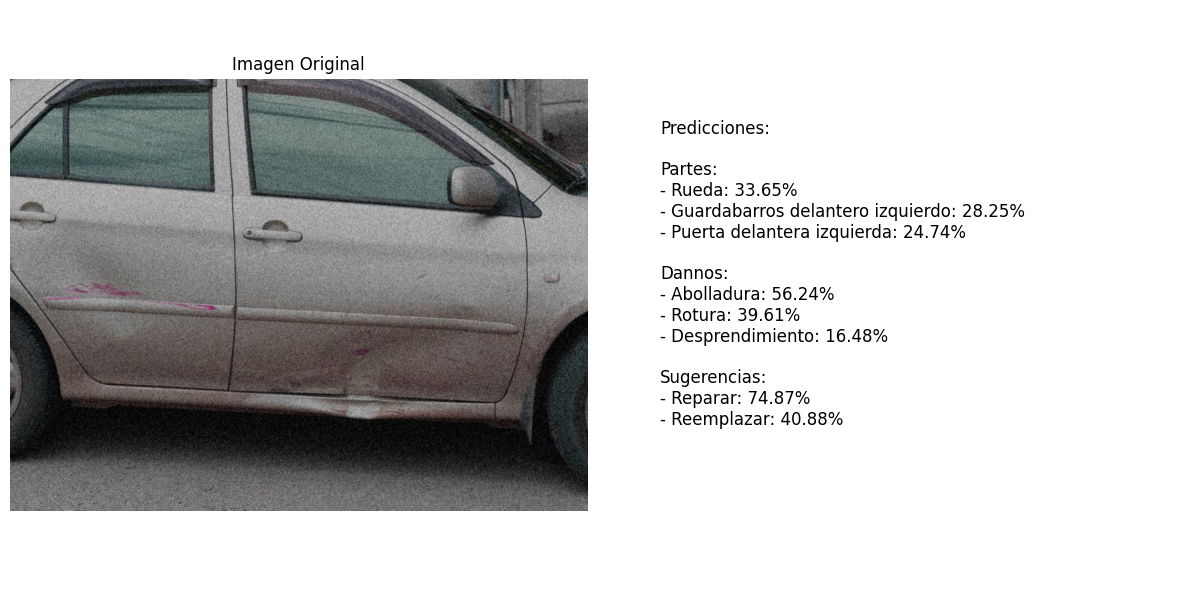

Resultados guardados en evaluation_results_fine_tuning.json


In [ ]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES CON VISUALIZACIÓN
# =============================================
def predict_and_show(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """
    Realiza predicciones para una nueva imagen y la muestra junto con los resultados
    
    Args:
        image_path: Ruta a la imagen a predecir
        model: Modelo cargado para hacer predicciones
        mlb_partes: MultiLabelBinarizer para partes
        mlb_dannos: MultiLabelBinarizer para daños
        mlb_sugerencias: MultiLabelBinarizer para sugerencias
        img_size: Tamaño de la imagen para redimensionamiento
    """
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # 1. Mostrar la imagen original
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis('off')
    
    # 2. Preprocesar la imagen para el modelo
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, img_size)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 3. Hacer predicción
    predictions = model.predict(img_array)
    
    # 4. Procesar resultados
    def get_top_predictions(classes, probs, label_dict, top_n=3):
        """Obtiene las top N predicciones con sus nombres y probabilidades"""
        top_items = sorted(zip(classes, probs[0]), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]
    
    resultados = {
        'partes': get_top_predictions(mlb_partes.classes_, predictions[0], label_to_cls_piezas),
        'dannos': get_top_predictions(mlb_dannos.classes_, predictions[1], label_to_cls_danos),
        'sugerencias': get_top_predictions(mlb_sugerencias.classes_, predictions[2], label_to_cls_sugerencias)
    }
    
    # 5. Mostrar resultados
    plt.subplot(1, 2, 2)
    text_content = "Predicciones:\n\n"
    
    for category, items in resultados.items():
        text_content += f"{category.capitalize()}:\n"
        if not items:
            text_content += "- No se identificaron predicciones significativas\n"
        else:
            for name, prob in items:
                text_content += f"- {name}: {prob:.2%}\n"
        text_content += "\n"
    
    plt.text(0.1, 0.5, text_content, fontsize=12, va='center')
    plt.axis('off')
    plt.tight_layout()
    
    # Mostrar todo
    plt.show()
    
    return resultados

# Visualización y predicción ejemplo
resultados = predict_and_show(
    image_path=image_path,
    model=model,
    mlb_partes=mlb_partes,
    mlb_dannos=mlb_dannos,
    mlb_sugerencias=mlb_sugerencias
)

In [ ]:
# Guardar resultados
def save_evaluation_results(results, filename='evaluation_results_fine_tuning.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

In [24]:
# =============================================
# GUARDAR RESULTADOS
# =============================================
def save_evaluation_results(results, filename='evaluation_results_fine_tuning_v2.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning_v2.json


---
cargar el modelo ya entrenado

In [25]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import applications
import os

# Diccionarios de mapeo (debe adaptarse si se usan otros)
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

def load_model(model_path):
    """
    Carga un modelo guardado en formato .keras o .h5 sin necesidad de reentrenar.
    """
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

def preprocess_image(image_path, img_size=(224, 224)):
    """
    Carga y preprocesa una imagen para la predicción.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(image_path, model, mlb_partes, mlb_danos, mlb_sugerencias):
    """
    Realiza predicción usando el modelo cargado para una imagen dada.
    """
    img_array = preprocess_image(image_path)
    predictions = model.predict(img_array)

    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]

    def get_top_predictions(classes, probs, label_dict, top_n=3):
        top_items = sorted(zip(classes, probs), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]

    partes_pred = get_top_predictions(mlb_partes.classes_, partes_probs, label_to_cls_piezas)
    dannos_pred = get_top_predictions(mlb_danos.classes_, dannos_probs, label_to_cls_danos)
    sugerencias_pred = get_top_predictions(mlb_sugerencias.classes_, sugerencias_probs, label_to_cls_sugerencias)

    return {
        'partes': partes_pred,
        'dannos': dannos_pred,
        'sugerencias': sugerencias_pred
    }

In [26]:
# Ejemplo de uso (adaptar mlb_* según su entorno)
if __name__ == "__main__":
    import pickle

    # Cargar modelo
    model_path = "final_model_fine_tuned_v2.keras"  # Cambiar si se usa otro archivo
    model = load_model(model_path)

    # Cargar MultiLabelBinarizer guardados (adaptar rutas)
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)

Modelo cargado desde final_model_fine_tuned_v2.keras


In [27]:
# Ruta imagen para predecir
image_path = "../data/predecir/golpe_01.jpg"

In [28]:
# Realizar predicción
prediction = predict(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)

print("Predicciones:")
for category, preds in prediction.items():
    print(f"\n{category.capitalize()}:")
    for name, prob in preds:
        print(f"- {name}: {prob:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
Predicciones:

Partes:
- Rueda: 34.73%
- Guardabarros delantero izquierdo: 27.82%
- Parachoques delantero: 24.46%

Dannos:
- Abolladura: 54.11%
- Rotura: 42.21%
- Desprendimiento: 17.35%

Sugerencias:
- Reparar: 73.02%
- Reemplazar: 43.34%


---